В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text

from process_bank_churn import preprocess_data

In [6]:
raw_df = pd.read_csv('train.csv')

In [7]:
X_train, train_targets, X_val, val_targets, input_cols, scaler, encoder = preprocess_data(raw_df, scale_numeric=False)

In [8]:
X_train.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,15652218.0,682.0,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24,1.0,0.0,0.0,0.0,1.0
10393,15592937.0,684.0,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31,1.0,0.0,0.0,1.0,0.0
80,15774586.0,705.0,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01,0.0,1.0,0.0,0.0,1.0
3365,15780572.0,669.0,58.0,0.0,0.00,2.0,0.0,1.0,51565.98,0.0,0.0,1.0,0.0,1.0
12236,15642099.0,707.0,21.0,3.0,0.00,2.0,1.0,1.0,148564.76,1.0,0.0,0.0,0.0,1.0


In [11]:
print(X_train.shape)
print(train_targets.shape)
print(X_val.shape)
print(val_targets.shape)

(12000, 14)
(12000,)
(3000, 14)
(3000,)


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [13]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [14]:
train_probs = knn.predict_proba(X_train)[:, 1]
val_probs = knn.predict_proba(X_val)[:, 1]

In [15]:
train_auc = roc_auc_score(train_targets, train_probs)
val_auc = roc_auc_score(val_targets, val_probs)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

Train AUROC: 0.8102
Validation AUROC: 0.5587


Модель має high variance (overfitting), бо Train AUROC = 0.81 значно вище за Validation AUROC = 0.56. Модель запам’ятала тренувальні дані, але не узагальнює на нові. Модель у такому вигляді є не надійною для прогнозу.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Параметрична сітка
param_grid = {
    'n_neighbors': list(range(1, 21))
}

# Базова модель
knn = KNeighborsClassifier()

# Налаштування GridSearchCV
grid_search = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Навчання
grid_search.fit(X_train, train_targets)

# Найкращий параметр
print("Найкраще значення n_neighbors:", grid_search.best_params_['n_neighbors'])

# Найкраща модель
knn_best = grid_search.best_estimator_

# AUROC на train/val
train_probs_best = knn_best.predict_proba(X_train)[:, 1]
val_probs_best = knn_best.predict_proba(X_val)[:, 1]

train_auc_best = roc_auc_score(train_targets, train_probs_best)
val_auc_best = roc_auc_score(val_targets, val_probs_best)

print(f"Train AUROC (best model): {train_auc_best:.4f}")
print(f"Validation AUROC (best model): {val_auc_best:.4f}")


Модель kNN після GridSearchCV трохи покращилась на валідації (AUROC =0.60), але залишилась значно гіршою за дерево рішень (AUROC =0.92).

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import time

# Сітка параметрів
param_grid = {
    'max_depth': list(range(1, 21, 2)),
    'max_leaf_nodes': list(range(2, 11))
}

# Базова модель з random_state
dtree = DecisionTreeClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

In [18]:
# Навчання з виміром часу
start_time = time.time()
grid_search.fit(X_train, train_targets)
end_time = time.time()

print(f"Час пошуку (сек): {end_time - start_time:.2f}")
print("Найкращі параметри:", grid_search.best_params_)

# Найкраща модель
dt_best = grid_search.best_estimator_

Час пошуку (сек): 5.97
Найкращі параметри: {'max_depth': 5, 'max_leaf_nodes': 10}


In [19]:
# Оцінка AUROC
train_probs = dt_best.predict_proba(X_train)[:, 1]
val_probs = dt_best.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(train_targets, train_probs)
val_auc = roc_auc_score(val_targets, val_probs)

print(f"Train AUROC (best tree): {train_auc:.4f}")
print(f"Validation AUROC (best tree): {val_auc:.4f}")

Train AUROC (best tree): 0.9015
Validation AUROC (best tree): 0.9002


GridSearchCV (5.97 с) знайшов оптимальні параметри max_depth=5, max_leaf_nodes=10. Модель показала Train AUROC ~0.90, Validation AUROC =0.90, що свідчить про високу якість та хорошу узагальнюваність. Якість трохи нижча за вручну підібрану модель (=0.92), але результат все ще дуже хороший.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import time

In [21]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [22]:
dtree = DecisionTreeClassifier(random_state=42)

In [23]:
random_search = RandomizedSearchCV(
    estimator=dtree,
    param_distributions=params_dt,
    n_iter=40,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

In [24]:
start_time = time.time()
random_search.fit(X_train, train_targets)
end_time = time.time()

print(f"Час пошуку (сек): {end_time - start_time:.2f}")

Час пошуку (сек): 1.65


In [25]:
print("Найкращі параметри:", random_search.best_params_)

Найкращі параметри: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': np.int64(14), 'max_features': None, 'max_depth': np.int64(16), 'criterion': 'entropy'}


In [26]:
dt_random_search_best = random_search.best_estimator_

In [27]:
train_probs = dt_random_search_best.predict_proba(X_train)[:, 1]
val_probs = dt_random_search_best.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(train_targets, train_probs)
val_auc = roc_auc_score(val_targets, val_probs)

print(f"Train AUROC (best random search tree): {train_auc:.4f}")
print(f"Validation AUROC (best random search tree): {val_auc:.4f}")

Train AUROC (best random search tree): 0.9169
Validation AUROC (best random search tree): 0.9166


RandomizedSearchCV дав Train AUROC ≈ 0.9169 та Validation AUROC ≈ 0.9166, що значно краще за GridSearchCV (~0.90). Це свідчить про кращу модель із ширшого простору параметрів і дає мені надію на кращий результат у змаганнях =)

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [39]:
print(dt_random_search_best)

DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(16),
                       max_leaf_nodes=np.int64(14), min_samples_leaf=2,
                       min_samples_split=20, random_state=42)


In [40]:
print(preprocessed_test.shape)
print(preprocessed_test.head())

(10000, 14)
   CustomerId  CreditScore   Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0  15594796.0        584.0  30.0     2.0  146053.66            1.0        1.0   
1  15642821.0        551.0  39.0     5.0       0.00            2.0        1.0   
2  15716284.0        706.0  43.0     8.0       0.00            2.0        1.0   
3  15785078.0        717.0  45.0     3.0       0.00            1.0        1.0   
4  15662955.0        592.0  43.0     8.0       0.00            2.0        1.0   

   IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0             1.0        157891.86               0.0                1.0   
1             1.0         67431.28               1.0                0.0   
2             0.0        156768.45               1.0                0.0   
3             1.0        166909.87               0.0                0.0   
4             1.0        143681.97               0.0                0.0   

   Geography_Spain  Gender_Female  Gender_Male  
0

In [41]:
proba_predictions = dt_random_search_best.predict_proba(preprocessed_test)[:, 1]
print(proba_predictions[:10])
print(proba_predictions.min(), proba_predictions.max())

[0.23791103 0.01211499 0.20394737 0.56984786 0.08217054 0.18763797
 0.01211499 0.01211499 0.05948553 0.01211499]
0.012114989733059548 1.0


In [46]:
proba_predictions = dt_random_search_best.predict_proba(preprocessed_test)[:, 1]

submission['Exited'] = proba_predictions

print(submission.head())

submission.to_csv('submission_decision_tree_RandomizedSearchCV.csv', index=False)

      id    Exited
0  15000  0.237911
1  15001  0.012115
2  15002  0.203947
3  15003  0.569848
4  15004  0.082171


In [47]:
from google.colab import files
files.download('submission_decision_tree_RandomizedSearchCV.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

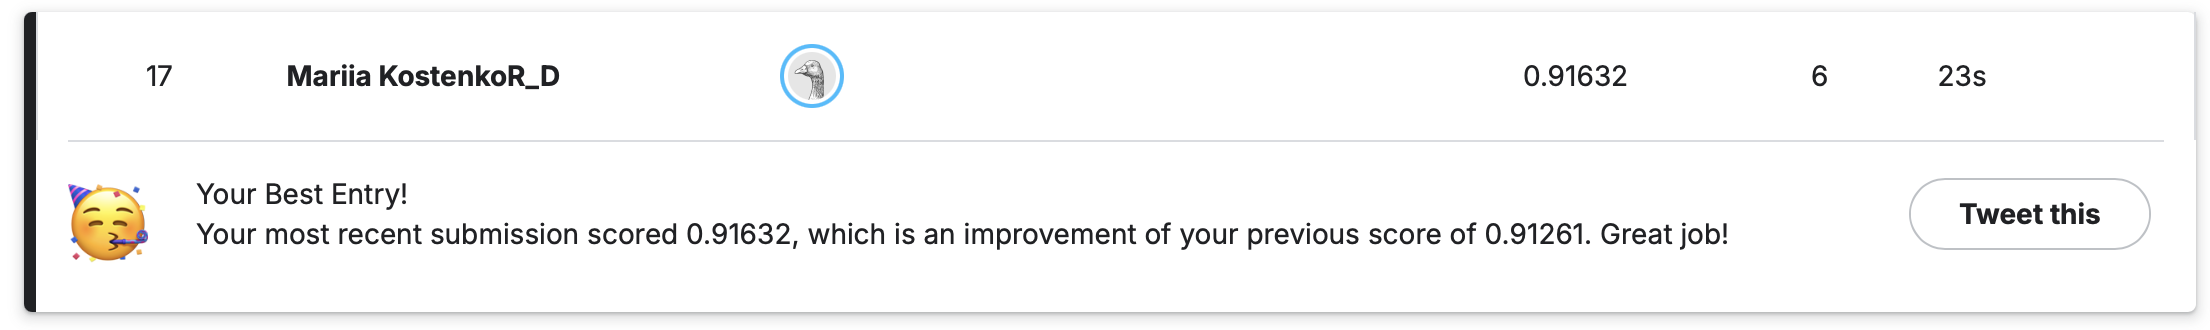